In [2]:
import numpy as np
from numpy.random import random
from scipy.spatial import Delaunay
import math
import matplotlib.pyplot as plt

#### Auxiliary methods

In [46]:
def circumcenter(points):
    #From https://gist.github.com/goretkin/3708293
    #Uses an extension of the method described here: http://www.ics.uci.edu/~eppstein/junkyard/circumcenter.html

    from numpy import bmat, hstack, dot, ones, zeros, sum, asarray
    from numpy.linalg import solve, norm
    
    pts = asarray(points)
    rows, cols = pts.shape
    assert(rows <= cols + 1)

    A = bmat( [[ 2 * dot(pts, pts.T), ones((rows, 1)) ],
               [  ones((1, rows)),   zeros((1, 1))  ]] )

    b = hstack((sum(pts * pts, axis=1), ones((1))))
    x = solve(A, b)
    bary_coords = x[:-1]           #barycentric coordinates of circumcenter
    return (pts*np.expand_dims(bary_coords, axis=1)).sum(axis=0)

def barycenter(simplex, points):
  #simplex contains indices of its vertices 
  return points[simplex].mean(axis=0)

#check whether the point lies in the boundind box 
def is_in_box(x, lim1, lim2):
    return not np.any(np.logical_or(x < lim1, x > lim2))

def simplex_volume(simplex_points):
    #Cayley-Menger determinant (https://mathworld.wolfram.com/Cayley-MengerDeterminant.html)
    dist_matrix = ((np.expand_dims(simplex_points, axis=0) - np.expand_dims(simplex_points, axis=1))**2).sum(axis=-1)
    B_hat = np.zeros((dist_matrix.shape[0] + 1, dist_matrix.shape[1] + 1))
    B_hat[1:, 1:] = dist_matrix
    B_hat[:, 0] = np.ones(B_hat[:, 0].shape)
    B_hat[0, :] = np.ones(B_hat[0, :].shape)
    B_hat[0,0] = 0
    j = len(simplex_points)-1
    det = np.linalg.det(B_hat)
    squared_score = ((-1)**(j+1)/((2**j)*(math.factorial(j)**2)))*det
    return math.sqrt(squared_score)

def score(simplex_points, f):
    vertices = simplex_points.copy()
    f_list = np.array([ f(x) for x in vertices ])
    lifted_vertices = np.concatenate( (vertices, np.expand_dims(f_list, axis=1)), axis=-1)
    return simplex_volume(lifted_vertices)

def get_evaluation_set(resolution):
    x = np.linspace(lim1, lim2, resolution)
    y = np.linspace(lim1, lim2, resolution)
    xx, yy = np.meshgrid(x, y)
    return np.hstack((np.reshape(xx, (-1, 1)), np.reshape(yy, (-1, 1))))

def evaluate_function(resolution, f):    
    return np.array([f(point) for point in get_evaluation_set(resolution)])

def evaluate_function_on_data(data, f):    
    return np.array([f(point) for point in data])

#draw background picture of the function 
def draw_function(f, axes, resolution, rescale=False):
    values = evaluate_function(resolution, f)
    values = values.reshape((resolution, resolution))
    values = np.flip(values, axis=0)
    axes.imshow(values , cmap='Blues', vmin=np.min(values) if rescale else global_min, vmax=np.max(values) if rescale else global_max, interpolation='nearest', extent=(lim1,lim2,lim1,lim2), alpha=1.)

#### Function parameters

In [41]:
#Function to be approximated. Some ideas are here: https://en.wikipedia.org/wiki/Test_functions_for_optimization
def rand_func(x):
    return random(1)
  #return (x**2).sum(axis=-1)
  #return x[0]**2 + x[1]**3

  #Ackley function
  #return -20*np.exp(-0.2*np.sqrt(0.5*((x**2).sum(axis=-1)))) - np.exp(0.5*np.cos(np.pi*x).sum(axis=-1)) + 23 
  #Rosenbrock function
 # return  (100*(x[1:] - x[:-1]**2)**2 + (1 - x[:-1])**2).sum(axis=-1)

  # if (x**2).sum() < 1:
  #   return 1
  # else:
  #   return 0

def himmelblau_like(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7) + 12

def himmelblau(x):
    return (x[0]**2 + x[1] - 11)**2 + (x[0] + x[1]**2 - 7)**2

def onlyx(x):
    return x[0]

def yx(x):
    return 10/(abs(x[0] + x[1]) + 10)

def gauss(x):
    return np.exp(-((x[0])**2 + (x[1])**2) / 10)

def cone(x):
    return math.sqrt(x[0]**2 + x[1]**2)

test_func = gauss

lim1, lim2 = -5, 5

num_iterations = 100
render_resolution = 200
values = evaluate_function(render_resolution, test_func)
global_min = min(values)
global_max = max(values)

# Evaluation
test_resolution = 100
ground_truth = evaluate_function(test_resolution, test_func)

In [21]:
random_points = random((10, 2)) * (lim2 - lim1) + lim1
random_points_and_corners = np.concatenate((random_points, np.array([[lim1, lim1], [lim1, lim2], [lim2, lim1], [lim2, lim2]])), axis=0)

## Delaunay interpolator

In [33]:
class DelaunayInterpolator:
    triangulation = None
    points = np.empty([0, 2])
    seeds_count = 0

    def __init__(self, seeds):
        self.seeds_count = len(seeds)
        self.add_points(seeds)

    def add_points(self, new_points):
        self.points = np.concatenate((self.points, new_points), axis=0)
        
        # Recomputing entire triangulation. Can be done more efficiently with Delaunay update algos
        self.triangulation = Delaunay(self.points).simplices

    def query_new_point(self):
        score_list = [(score(self.points[simplex], test_func), simplex)
                      for simplex in self.triangulation if is_in_box(circumcenter(self.points[simplex]), lim1, lim2)]

        # Can be more efficiently implemented with a p-queue (heap)
        best_simplex = max(score_list, key=lambda a : a[0])[1]
        new_point = circumcenter(self.points[best_simplex])

        self.add_points([new_point])

    def run(self, iteration_count):
        for _ in range(iteration_count):
            self.query_new_point()

    def evaluate(self, point):
        # A smart algo (like kd-tree?) can be used to find the cell faster than O(N)
        #cell = min(self.points, key=lambda p: np.sum(np.square(p - point)))
        cell = self.points[0]
        for p in self.points:
            if (p[0] - point[0])**2 + (p[1] - point[1])** 2 < (cell[0] - point[0])**2 + (cell[1] - point[1])** 2:
                cell = p
        return test_func(cell)

    def plot_points(self, axes):
        axes.scatter(self.points[:self.seeds_count, 0], self.points[:self.seeds_count, 1], c='Red')
        axes.scatter(self.points[self.seeds_count:, 0], self.points[self.seeds_count:, 1], c='Orange')

    def plot_partitioning(self, axes):
        for simplex in self.triangulation:
            for i in range(len(simplex)):
                for j in range(i, len(simplex)):
                    axes.plot([self.points[simplex[i]][0], self.points[simplex[j]][0]],
                              [self.points[simplex[i]][1], self.points[simplex[j]][1]],
                              c='Black', linewidth=0.5)

    def plot(self, axes, partitioning=True):
        self.plot_points(axes)
        if partitioning:
            self.plot_partitioning(axes)

### Initialization experiments

#### Random points initialization

[(4.655343066856341, array([1, 2, 9], dtype=int32)), (0.7264209610934033, array([5, 6, 7], dtype=int32)), (3.182996721210887, array([6, 5, 9], dtype=int32)), (2.8040067713906867, array([5, 3, 9], dtype=int32)), (1.4753579992693922, array([1, 3, 0], dtype=int32)), (6.826062190793627, array([3, 1, 9], dtype=int32)), (7.8420009260517185, array([2, 4, 8], dtype=int32)), (6.280399891122172, array([1, 4, 2], dtype=int32))]
[(4.655343066856341, array([1, 2, 9], dtype=int32)), (0.7264209610934033, array([5, 6, 7], dtype=int32)), (3.182996721210887, array([6, 5, 9], dtype=int32)), (2.8040067713906867, array([5, 3, 9], dtype=int32)), (1.4753579992693922, array([1, 3, 0], dtype=int32)), (6.826062190793627, array([3, 1, 9], dtype=int32)), (2.781149544862587, array([ 4, 10,  2], dtype=int32)), (6.280399891122172, array([1, 4, 2], dtype=int32))]
[(2.3553490074156453, array([11,  2,  9], dtype=int32)), (3.608731895281016, array([ 5, 11,  9], dtype=int32)), (3.813000102084227, array([11, 10,  2], dtyp

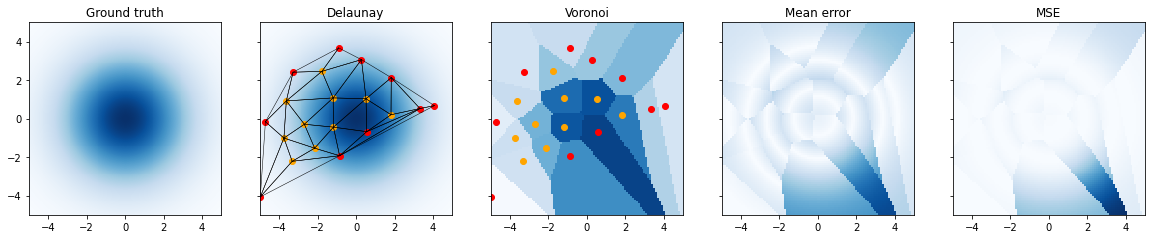

In [18]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4), sharex=True, sharey=True)
axes = axes.ravel()
for ax in axes:
    ax.set_aspect(1)

ours = DelaunayInterpolator(random_points)
ours.run(num_iterations)

draw_function(test_func, axes[0], render_resolution)
axes[0].set_title('Ground truth')

draw_function(test_func, axes[1], render_resolution)
ours.plot(axes[1])
axes[1].set_title('Delaunay')

ours.plot(axes[2], partitioning=False)
draw_function(ours.evaluate, axes[2], test_resolution)
axes[2].set_title('Voronoi')

draw_function(lambda x: abs(test_func(x) - ours.evaluate(x)), axes[3], test_resolution)
axes[3].set_title('Mean error')

draw_function(lambda x: (test_func(x) - ours.evaluate(x))**2, axes[4], test_resolution, rescale=True)
axes[4].set_title('MSE')

print(f'Mean error: {np.average(abs(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Mean squared error: {np.average(np.square(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')

plt.show()

[(90.18992051293888, array([1, 2, 9], dtype=int32)), (13.488452898979881, array([5, 6, 7], dtype=int32)), (62.495539719121844, array([6, 5, 9], dtype=int32)), (42.75589924225489, array([5, 3, 9], dtype=int32)), (18.36943437075065, array([1, 3, 0], dtype=int32)), (107.8585992627155, array([3, 1, 9], dtype=int32)), (112.816894311211, array([2, 4, 8], dtype=int32)), (79.25134925361532, array([1, 4, 2], dtype=int32))]
[(90.18992051293888, array([1, 2, 9], dtype=int32)), (13.488452898979881, array([5, 6, 7], dtype=int32)), (62.495539719121844, array([6, 5, 9], dtype=int32)), (42.75589924225489, array([5, 3, 9], dtype=int32)), (18.36943437075065, array([1, 3, 0], dtype=int32)), (107.8585992627155, array([3, 1, 9], dtype=int32)), (50.09615780001793, array([ 4, 10,  2], dtype=int32)), (79.25134925361532, array([1, 4, 2], dtype=int32))]
[(37.45905644485847, array([11,  2,  9], dtype=int32)), (54.67956168885918, array([ 5, 11,  9], dtype=int32)), (68.1772482401411, array([11, 10,  2], dtype=int3

Mean error: 18.09803924261757
Mean squared error: 665.2703969054268


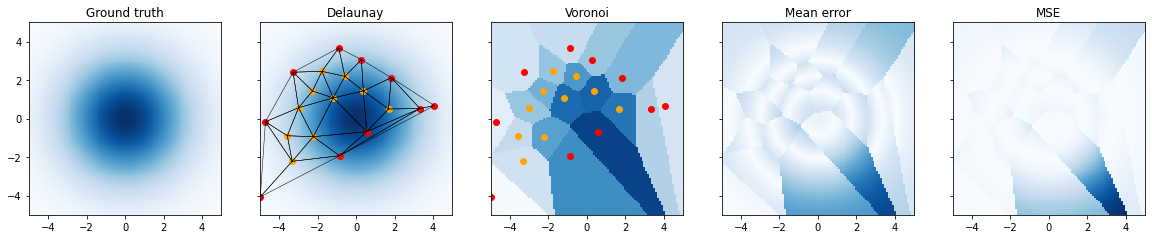

In [16]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4), sharex=True, sharey=True)
axes = axes.ravel()
for ax in axes:
    ax.set_aspect(1)

ours = DelaunayInterpolator(random_points)
ours.run(num_iterations)

draw_function(test_func, axes[0], render_resolution)
axes[0].set_title('Ground truth')

draw_function(test_func, axes[1], render_resolution)
ours.plot(axes[1])
axes[1].set_title('Delaunay')

ours.plot(axes[2], partitioning=False)
draw_function(ours.evaluate, axes[2], test_resolution)
axes[2].set_title('Voronoi')

draw_function(lambda x: abs(test_func(x) - ours.evaluate(x)), axes[3], test_resolution)
axes[3].set_title('Mean error')

draw_function(lambda x: (test_func(x) - ours.evaluate(x))**2, axes[4], test_resolution, rescale=True)
axes[4].set_title('MSE')

print(f'Mean error: {np.average(abs(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Mean squared error: {np.average(np.square(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')

plt.show()

#### Random points + corners initialization

Mean error: 16.848992666944852
Mean squared error: 716.23585500697


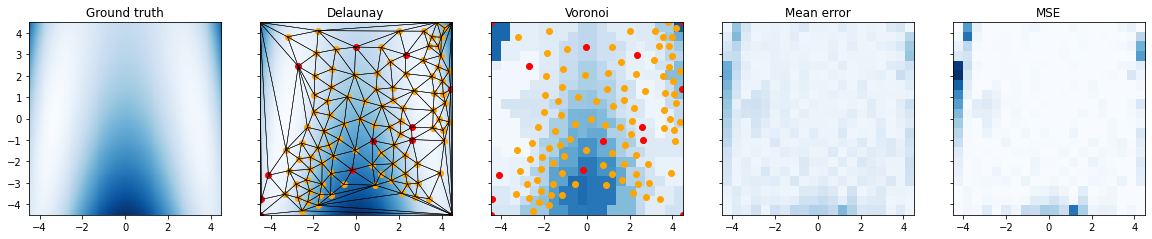

In [ ]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4), sharex=True, sharey=True)
axes = axes.ravel()
for ax in axes:
    ax.set_aspect(1)

ours = DelaunayInterpolator(random_points_and_corners)
ours.run(num_iterations - (len(random_points_and_corners) - len(random_points)))

draw_function(test_func, axes[0], render_resolution)
axes[0].set_title('Ground truth')

draw_function(test_func, axes[1], render_resolution)
ours.plot(axes[1])
axes[1].set_title('Delaunay')

ours.plot(axes[2], partitioning=False)
draw_function(ours.evaluate, axes[2], test_resolution)
axes[2].set_title('Voronoi')

draw_function(lambda x: abs(test_func(x) - ours.evaluate(x)), axes[3], test_resolution)
axes[3].set_title('Mean error')

draw_function(lambda x: (test_func(x) - ours.evaluate(x))**2, axes[4], test_resolution, rescale=True)
axes[4].set_title('MSE')

print(f'Mean error: {np.average(abs(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Mean squared error: {np.average(np.square(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')

plt.show()

### Next point query

#### Query a boundary point in that direction if circumference is outside

In [24]:
class DelaunayInterpolatorBoundaryIntersect(DelaunayInterpolator):
    def query_new_point(self):
        score_list = []
        for simplex in self.triangulation:
            if is_in_box(circumcenter(self.points[simplex]), lim1, lim2):
                score_list.append((score(self.points[simplex], test_func), circumcenter(self.points[simplex])))
            else:
                # if the circumcenter is not in the box, it is not inside simplex => line through it and a vertex opposite to the largest facet intersects the bounding box (I guess?)
                facet_volumes = [(point, simplex_volume([vertex for vertex in self.points[simplex] if not (vertex == point).all()])) for point in self.points[simplex]]
                point_0 = max(facet_volumes, key=lambda x: x[1])[0]
                point_1 = circumcenter(self.points[simplex])

                # enumerate bounding hyperplanes and check if the segment intersects any
                n = 2 # dimensions
                new_point = None
                for d in range(n):
                    for d_value in [lim1, lim2]:
                        # segment endpoints should be on different sides on d axis
                        if (point_0[d] - d_value) * (point_1[d] - d_value) < 0:
                            ratio = (d_value - point_0[d]) / (point_1[d] - point_0[d])
                            intersection = [ratio * (point_1[x] - point_0[x]) + point_0[x] for x in range(n)]
                            intersects = True
                            for x in range(n):
                                if not lim1 <= x <= lim2:
                                    intersects = False
                                    break
                            if intersects:
                                new_point = intersection
                                break
                    if new_point:
                        break
                if new_point:
                    score_list.append((score(self.points[simplex], test_func), new_point))
        
        # Can be more efficiently implemented with a p-queue (heap)
        best_point = max(score_list, key=lambda a : a[0])[1]
        self.add_points([best_point])

KeyboardInterrupt: 

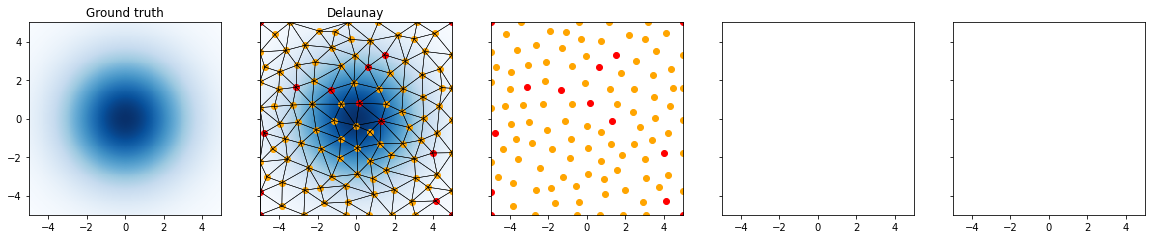

In [25]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4), sharex=True, sharey=True)
axes = axes.ravel()
for ax in axes:
    ax.set_aspect(1)

ours = DelaunayInterpolatorBoundaryIntersect(random_points_and_corners)
ours.run(num_iterations - (len(random_points_and_corners) - len(random_points)))

draw_function(test_func, axes[0], render_resolution)
axes[0].set_title('Ground truth')

draw_function(test_func, axes[1], render_resolution)
ours.plot(axes[1])
axes[1].set_title('Delaunay')

ours.plot(axes[2], partitioning=False)
draw_function(ours.evaluate, axes[2], test_resolution)
axes[2].set_title('Voronoi')

draw_function(lambda x: abs(test_func(x) - ours.evaluate(x)), axes[3], test_resolution)
axes[3].set_title('Mean error')

draw_function(lambda x: (test_func(x) - ours.evaluate(x))**2, axes[4], test_resolution, rescale=True)
axes[4].set_title('MSE')

print(f'Mean error: {np.average(abs(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Mean squared error: {np.average(np.square(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Total points: {len(ours.points)}')

plt.show()

## Baseline (recursive partitioning)

In [26]:
from defer.helpers import *
from defer.variables import Variable
from defer.tree import find_leaf

import warnings
warnings.filterwarnings('ignore')

infinity_limit = 1000000000000

In [27]:
#implementation of the baseline: https://arxiv.org/abs/2010.13632

class PartitioningInterpolator:
    approximator = None
    paritions = None

    # Since the new points cannot be added one by one, you can limit the total number of partitions
    def run(self, max_partition_count, evaluation_frequency=None, evaluation_set=np.array([]), evaluation_metrics=[]):
        if not evaluation_frequency:
            evaluation_frequency = max_partition_count * 2
            evaluation_set = np.array([])

        x = Variable(
            lower=[lim1, lim1],
            upper=[lim2, lim2],
            name="x")
        variables = Variables([x])
        
        score_curve = []
        self.approximator = construct(
            fn=test_func,
            variables=variables,
            is_log_fn=False,
            num_fn_calls=max_partition_count,
            callback=lambda iteration_count, approximator:
                score_curve.append([approximator.num_partitions,
                                    self.evaluate_set(approximator.tree, evaluation_set, evaluation_metrics)]),
            callback_freq_fn_calls=evaluation_frequency)
        self.partitions = self.approximator.all_partitions()
        
        return score_curve

    def evaluate_set(self, current_tree, evaluation_set, metrics):
        evaluation_results = [self.evaluate_tree(current_tree, point) for point in evaluation_set]
        return [metric(evaluation_set, evaluation_results) for metric in metrics] if evaluation_set.size else []

    def evaluate_tree(self, tree, point):
        partition = find_leaf(tree, point)
        return partition.f
        
    def evaluate(self, point):
        partition = find_leaf(self.approximator.tree, point)
        return partition.f

    def plot_points(self, axes):
        points = np.asarray([partition.domain.center_vector for partition in self.partitions])
        axes.scatter(points[:, 0], points[:, 1], c='Orange')

    def plot_partitioning(self, axes):
        for partition in self.partitions:
            lo = partition.domain.lower_limit_vector
            hi = partition.domain.upper_limit_vector
            axes.plot([lo[0], hi[0]], [lo[1], lo[1]], c='Black',  linewidth=0.5)
            axes.plot([lo[0], lo[0]], [lo[1], hi[1]], c='Black',  linewidth=0.5)

    def plot(self, axes, partitioning=True):
        self.plot_points(axes)
        if partitioning:
            self.plot_partitioning(axes)

Mean error: 12.967834273298983
Mean squared error: 369.22996695383296
Total points: 115


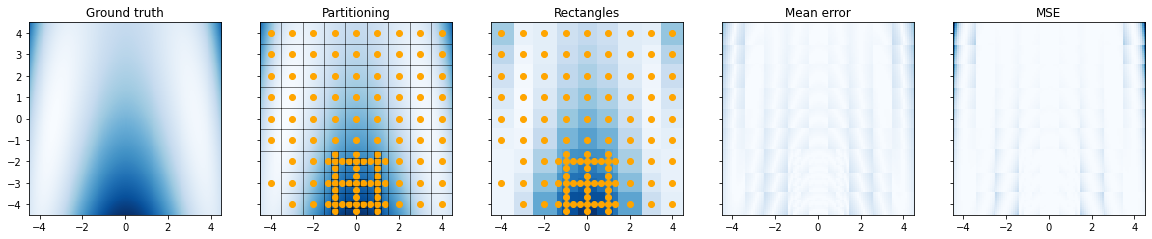

In [80]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4), sharex=True, sharey=True)
axes = axes.ravel()
for ax in axes:
    ax.set_aspect(1)

ours = PartitioningInterpolator()
ours.run(max_partition_count=num_iterations + len(random_points))

draw_function(test_func, axes[0], render_resolution)
axes[0].set_title('Ground truth')

draw_function(test_func, axes[1], render_resolution)
ours.plot(axes[1])
axes[1].set_title('Partitioning')

ours.plot(axes[2], partitioning=False)
draw_function(ours.evaluate, axes[2], test_resolution)
axes[2].set_title('Rectangles')

draw_function(lambda x: abs(test_func(x) - ours.evaluate(x)), axes[3], test_resolution)
axes[3].set_title('Mean error')

draw_function(lambda x: (test_func(x) - ours.evaluate(x))**2, axes[4], test_resolution, rescale=True)
axes[4].set_title('MSE')

print(f'Mean error: {np.average(abs(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Mean squared error: {np.average(np.square(evaluate_function(test_resolution, ours.evaluate) - evaluate_function(test_resolution, test_func)))}')
print(f'Total points: {len(ours.partitions)}')

plt.show()

### Comparison

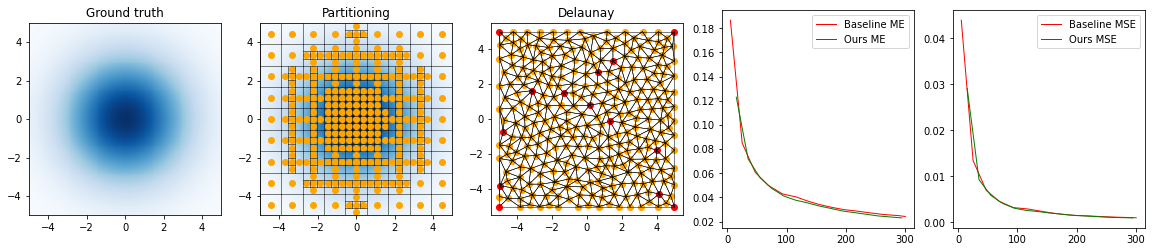

In [45]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4))
axes = axes.ravel()

draw_function(test_func, axes[0], render_resolution)
axes[0].set_aspect(1)
axes[0].set_title('Ground truth')

max_iterations = 300

ground_truth_evaluation = evaluate_function(test_resolution, test_func)

# Baseline
baseline = PartitioningInterpolator()
me = lambda data, results: np.average(abs(evaluate_function_on_data(data, test_func) - results))
mse = lambda data, results: np.average(np.square(evaluate_function_on_data(data, test_func) - results))
results = baseline.run(max_partition_count=max_iterations,
                       evaluation_frequency=20,
                       evaluation_set=get_evaluation_set(test_resolution),
                       evaluation_metrics=[me, mse])
results = np.asarray(results)
baseline_me = [metrics[0] for metrics in results[:, 1]]
baseline_mse = [metrics[1] for metrics in results[:, 1]]

axes[3].plot(results[:, 0], baseline_me, label='Baseline ME', c='Red', linewidth=1)
axes[4].plot(results[:, 0], baseline_mse, label='Baseline MSE', c='Red', linewidth=1)

draw_function(test_func, axes[1], render_resolution)
baseline.plot(axes[1])
axes[1].set_aspect(1)
axes[1].set_title('Partitioning')

# Ours

ours = DelaunayInterpolatorBoundaryIntersect(random_points_and_corners)
ours_me = []
ours_mse = []
for i in range(max_iterations - len(random_points_and_corners)):
    ours.run(iteration_count=1)
    if i % 20 == 0:
        # save time by evaluating only every 10 iterations
        evaluation = evaluate_function(test_resolution, ours.evaluate)
        ours_me.append((len(ours.points), np.average(abs(evaluation - ground_truth_evaluation))))
        ours_mse.append((len(ours.points), np.average(np.square(evaluation - ground_truth_evaluation))))

ours_me = np.asarray(ours_me)
ours_mse = np.asarray(ours_mse)
axes[3].plot(ours_me[:, 0], ours_me[:, 1], label='Ours ME', c='Green', linewidth=1)
axes[4].plot(ours_mse[:, 0], ours_mse[:, 1], label='Ours MSE', c='Green', linewidth=1)

#draw_function(test_func, axes[2], render_resolution)
ours.plot(axes[2])
axes[2].set_aspect(1)
axes[2].set_title('Delaunay')

axes[3].legend()
axes[4].legend()

plt.show()

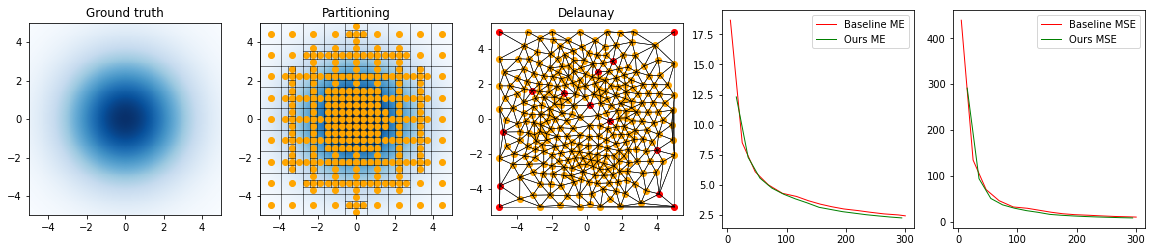

In [36]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4))
axes = axes.ravel()

draw_function(test_func, axes[0], render_resolution)
axes[0].set_aspect(1)
axes[0].set_title('Ground truth')

max_iterations = 300

ground_truth_evaluation = evaluate_function(test_resolution, test_func)

# Baseline
baseline = PartitioningInterpolator()
me = lambda data, results: np.average(abs(evaluate_function_on_data(data, test_func) - results))
mse = lambda data, results: np.average(np.square(evaluate_function_on_data(data, test_func) - results))
results = baseline.run(max_partition_count=max_iterations,
                       evaluation_frequency=20,
                       evaluation_set=get_evaluation_set(test_resolution),
                       evaluation_metrics=[me, mse])
results = np.asarray(results)
baseline_me = [metrics[0] for metrics in results[:, 1]]
baseline_mse = [metrics[1] for metrics in results[:, 1]]

axes[3].plot(results[:, 0], baseline_me, label='Baseline ME', c='Red', linewidth=1)
axes[4].plot(results[:, 0], baseline_mse, label='Baseline MSE', c='Red', linewidth=1)

draw_function(test_func, axes[1], render_resolution)
baseline.plot(axes[1])
axes[1].set_aspect(1)
axes[1].set_title('Partitioning')

# Ours

ours = DelaunayInterpolatorBoundaryIntersect(random_points_and_corners)
ours_me = []
ours_mse = []
for i in range(max_iterations - len(random_points_and_corners)):
    ours.run(iteration_count=1)
    if i % 20 == 0:
        # save time by evaluating only every 10 iterations
        evaluation = evaluate_function(test_resolution, ours.evaluate)
        ours_me.append((len(ours.points), np.average(abs(evaluation - ground_truth_evaluation))))
        ours_mse.append((len(ours.points), np.average(np.square(evaluation - ground_truth_evaluation))))

ours_me = np.asarray(ours_me)
ours_mse = np.asarray(ours_mse)
axes[3].plot(ours_me[:, 0], ours_me[:, 1], label='Ours ME', c='Green', linewidth=1)
axes[4].plot(ours_mse[:, 0], ours_mse[:, 1], label='Ours MSE', c='Green', linewidth=1)

#draw_function(test_func, axes[2], render_resolution)
ours.plot(axes[2])
axes[2].set_aspect(1)
axes[2].set_title('Delaunay')

axes[3].legend()
axes[4].legend()

plt.show()

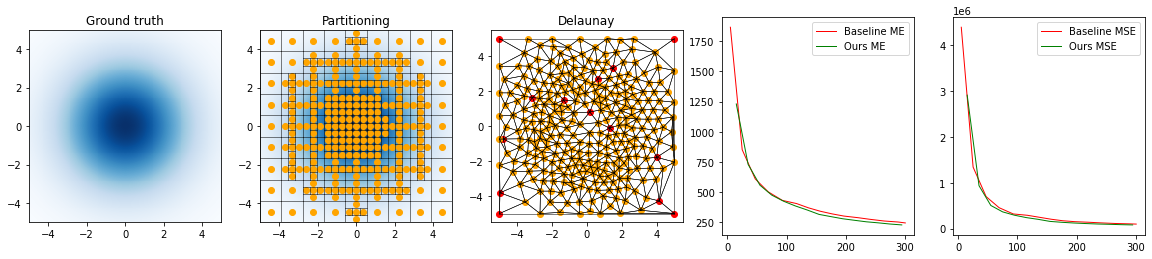

In [38]:
plot_count = 5
figure, axes = plt.subplots(1, plot_count, figsize=(4 * plot_count, 4))
axes = axes.ravel()

draw_function(test_func, axes[0], render_resolution)
axes[0].set_aspect(1)
axes[0].set_title('Ground truth')

max_iterations = 300

ground_truth_evaluation = evaluate_function(test_resolution, test_func)

# Baseline
baseline = PartitioningInterpolator()
me = lambda data, results: np.average(abs(evaluate_function_on_data(data, test_func) - results))
mse = lambda data, results: np.average(np.square(evaluate_function_on_data(data, test_func) - results))
results = baseline.run(max_partition_count=max_iterations,
                       evaluation_frequency=20,
                       evaluation_set=get_evaluation_set(test_resolution),
                       evaluation_metrics=[me, mse])
results = np.asarray(results)
baseline_me = [metrics[0] for metrics in results[:, 1]]
baseline_mse = [metrics[1] for metrics in results[:, 1]]

axes[3].plot(results[:, 0], baseline_me, label='Baseline ME', c='Red', linewidth=1)
axes[4].plot(results[:, 0], baseline_mse, label='Baseline MSE', c='Red', linewidth=1)

draw_function(test_func, axes[1], render_resolution)
baseline.plot(axes[1])
axes[1].set_aspect(1)
axes[1].set_title('Partitioning')

# Ours

ours = DelaunayInterpolatorBoundaryIntersect(random_points_and_corners)
ours_me = []
ours_mse = []
for i in range(max_iterations - len(random_points_and_corners)):
    ours.run(iteration_count=1)
    if i % 20 == 0:
        # save time by evaluating only every 10 iterations
        evaluation = evaluate_function(test_resolution, ours.evaluate)
        ours_me.append((len(ours.points), np.average(abs(evaluation - ground_truth_evaluation))))
        ours_mse.append((len(ours.points), np.average(np.square(evaluation - ground_truth_evaluation))))

ours_me = np.asarray(ours_me)
ours_mse = np.asarray(ours_mse)
axes[3].plot(ours_me[:, 0], ours_me[:, 1], label='Ours ME', c='Green', linewidth=1)
axes[4].plot(ours_mse[:, 0], ours_mse[:, 1], label='Ours MSE', c='Green', linewidth=1)

#draw_function(test_func, axes[2], render_resolution)
ours.plot(axes[2])
axes[2].set_aspect(1)
axes[2].set_title('Delaunay')

axes[3].legend()
axes[4].legend()

plt.show()

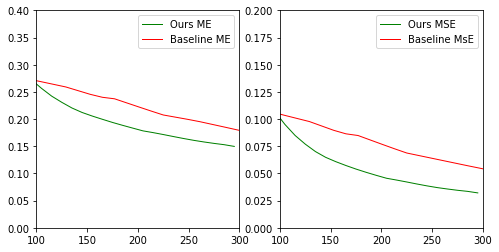

In [39]:
figure, axes = plt.subplots(1, 2, figsize=(4 * 2, 4))

axes[0].plot(ours_me[:, 0], ours_me[:, 1], label='Ours ME', c='Green', linewidth=1)
axes[0].plot(results[:, 0], [metrics[0] for metrics in results[:, 1]], label='Baseline ME', c='Red', linewidth=1)

axes[1].plot(ours_mse[:, 0], ours_mse[:, 1], label='Ours MSE', c='Green', linewidth=1)
axes[1].plot(results[:, 0], [metrics[1] for metrics in results[:, 1]], label='Baseline MSE', c='Red', linewidth=1)

axes[0].legend()
axes[1].legend()

axes[0].set_xlim((100,300))
axes[0].set_ylim((0,0.4))

axes[1].set_xlim((100,300))
axes[1].set_ylim((0,0.2))

plt.show()